# Basic Example for Graphical Causal Models

## Step 1: Modeling cause-effect relationships as a structural causal model (SCM)

The first step is to model the cause-effect relationships between variables relevant to our use case. We do that in form of a causal graph. A causal graph is a directed acyclic graph (DAG) where an edge X→Y implies that X causes Y. Statistically, a causal graph encodes the conditional independence relations between variables. Using the [NetworkX](https://networkx.org/) library, we can create causal graphs. In the snippet below, we create a chain X→Y→Z:



In [1]:
import networkx as nx
causal_graph = nx.DiGraph([('X', 'Y'), ('Y', 'Z')])

To answer causal questions using causal graphs, we also have to know the nature of underlying data-generating process of variables. A causal graph by itself, being a diagram, does not have any information about the data-generating process. To introduce this data-generating process, we use an SCM that’s built on top of our causal graph:


In [2]:
from dowhy import gcm
causal_model = gcm.StructuralCausalModel(causal_graph)

At this point we would normally load our dataset. For this introduction, we generate
some synthetic data instead. The API takes data in form of Pandas DataFrames:

In [3]:
import numpy as np, pandas as pd

X = np.random.normal(loc=0, scale=1, size=1000)
Y = 2 * X + np.random.normal(loc=0, scale=1, size=1000)
Z = 3 * Y + np.random.normal(loc=0, scale=1, size=1000)
data = pd.DataFrame(data=dict(X=X, Y=Y, Z=Z))
data.head()

X         Y         Z
0  0.322509  2.889543  7.999584
1  0.529368  1.238352  3.713945
2  0.408486  1.922315  5.178745
3 -0.657048 -0.943606 -2.612721
4 -0.150601 -0.640273 -1.782792

Note how the columns X, Y, Z correspond to our nodes X, Y, Z in the graph constructed above. We can also see how the
values of X influence the values of Y and how the values of Y influence the values of Z in that data set.

The causal model created above allows us now to assign causal mechanisms to each node in the form of functional causal
models. Here, these mechanism can either be assigned manually if, for instance, prior knowledge about certain causal
relationships are known or they can be assigned automatically using the `auto` module. For the latter,
we simply call:

In [4]:
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data)

Optionally, we can get more insights from the auto assignment process:

In [5]:
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

In case we want to have more control over the assigned mechanisms, we can do this manually as well. For instance, we can
can assign an empirical distribution to the root node X and linear additive noise models to nodes Y and Z:

In [6]:
causal_model.set_causal_mechanism('X', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('Y', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Z', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

Here, we set node X to follow the empirical distribution we observed (nonparametric) and nodes Y and Z to follow an additive noise model where we explicitly set a linear relationship.

In the real world, the data comes as an opaque stream of values, where we typically don't know how one
variable influences another. The graphical causal models can help us to deconstruct these causal
relationships again, even though we didn't know them before.

## Step 2: Fitting the SCM to the data

With the data at hand and the graph constructed earlier, we can now train the SCM using `fit`:

In [7]:
gcm.fit(causal_model, data)

Fitting causal models:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node X:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node Y:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node Z:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node Z: 100%|██████████| 3/3 [00:00<00:00, 431.39it/s]

Fitting means, we learn the generative models of the variables in the SCM according to the data.

Once fitted, we can also obtain more insights into the model performances:

Evaluating causal mechanisms...:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating causal mechanisms...: 100%|██████████| 3/3 [00:00<00:00, 3126.97it/s]

Test permutations of given graph:   0%|          | 0/6 [00:00<?, ?it/s]

Test permutations of given graph:  33%|███▎      | 2/6 [00:00<00:00, 12.20it/s]

Test permutations of given graph:  67%|██████▋   | 4/6 [00:00<00:00, 12.61it/s]

Test permutations of given graph: 100%|██████████| 6/6 [00:00<00:00, 18.64it/s]

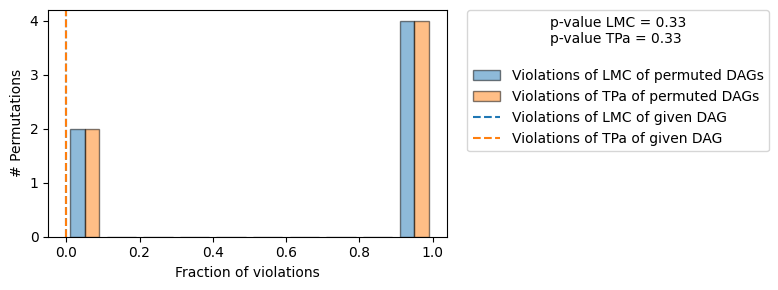

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [8]:
print(gcm.evaluate_causal_model(causal_model, data))

This summary tells us a few things:
- Our models are a good fit.
- The additive noise model assumption was not rejected.
- The generated distribution is very similar to the observed one.
- The causal graph structure was not rejected.

> Note, this evaluation can take some significant time depending on the model complexities, graph size and amount of data. For a speed-up, consider changing the evaluation parameters.

## Step 3: Answering a causal query based on the SCM

The last step, answering a causal question, is our actual goal. E.g. we could ask the question "What will happen to the variable Z if I intervene on Y?".

This can be done via the `interventional_samples` function. Here’s how:

In [9]:
samples = gcm.interventional_samples(causal_model,
                                     {'Y': lambda y: 2.34 },
                                     num_samples_to_draw=1000)
samples.head()

X     Y         Z
0  1.100304  2.34  7.007176
1  1.340453  2.34  6.128374
2 -0.684661  2.34  8.076388
3  0.253986  2.34  7.628337
4 -0.388024  2.34  7.549850

This intervention says: "I'll ignore any causal effects of X on Y, and set every value of Y to 2.34." So the distribution of X will remain unchanged, whereas values of Y will be at a fixed value and Z will respond according to its causal model.

> DoWhy offers a wide range of causal questions that can be answered with GCMs. See the user guide or other notebooks for more examples.